In [13]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from pyod.models.lof import LOF
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import json

In [44]:
import pickle
from sklearn.preprocessing import StandardScaler
with open('../data/boiler/state424.pkl', 'rb') as f:
    data = pickle.load(f)
graph = data['graph']
label = data['label']
data = data['data']

scaler = StandardScaler()
data = scaler.fit_transform(data)

np.save('../data/boiler/X_train.npy', data)
np.save('../data/boiler/y_train.npy', data)
np.save('../data/boiler/X_test.npy', data[label])
np.save('../data/boiler/y_test.npy', data[label])
np.save('../data/boiler/boiler.npy', graph)

In [47]:
len(data[~label])

42994

In [38]:
datadir = '../data/boiler/'

# anomaly
x2 = np.load(datadir + 'std1.npy').squeeze()
y2 = np.load(datadir + 'mu_loss1.npy').squeeze()
# normal
x1 = np.load(datadir + 'std.npy').squeeze()
y1 = np.load(datadir + 'mu_loss.npy').squeeze()

x2sum = np.sum(x2, axis = 1).squeeze()
y2sum = np.sum(y2, axis = 1).squeeze()
x1sum = np.sum(x1, axis = 1).squeeze()
y1sum = np.sum(y1, axis = 1).squeeze()

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy as np

# data generation for locdoor

df = pd.read_csv('../data/UJIndoorLoc/trainingData.csv')
for head in df.columns:
    if head[:3] != 'WAP' and head[0] != 'L' and head != 'BUILDINGID':
        df = df.drop([head], axis=1)
anomaly_data = df[df['BUILDINGID'] == 0]
normal_data = df[df['BUILDINGID'] == 2]

anomaly_data = np.array(anomaly_data.drop(['BUILDINGID'], axis=1))
normal_data = np.array(normal_data.drop(['BUILDINGID'], axis=1))

scaler = StandardScaler()
anomaly_data = scaler.fit_transform(anomaly_data)
normal_data = scaler.fit_transform(normal_data)

X_train = np.concatenate((normal_data, anomaly_data[:508]))
y_train = np.concatenate((np.zeros(len(normal_data)), np.ones(508)))

X_test = X_train[y_train == 0]
y_test = y_train[y_train == 0]

np.save('../data/UJIndoorLoc/X_train.npy', X_train)
np.save('../data/UJIndoorLoc/X_test.npy', X_test)
np.save('../data/UJIndoorLoc/y_train.npy', y_train)
np.save('../data/UJIndoorLoc/y_test.npy', y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 522) (10000,) (9492, 522) (9492,)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy as np

# data generation for front

data_path = ['../data/fonts/OCRB.csv', '../data/fonts/HANDPRINT.csv']

total_data = []
total_lable = []
for i in range(len(data_path)):
    data = pd.read_csv(data_path[i])
    data = data[data['strength'] == 0.4]
    for head in data.columns:
        if head[0] != 'r':
            data = data.drop([head], axis=1)
    if i == 0:
        total_data = np.array(data)[:45000]
        total_lable = np.zeros(len(data))[:45000]
    else:
        total_data = np.concatenate((total_data, data[:5000]), axis=0)
        total_lable = np.concatenate((total_lable, np.ones(5000)))
    
scaler = StandardScaler()
total_data = scaler.fit_transform(total_data)

X_train, X_test, y_train, y_test = train_test_split(total_data, total_lable, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# X_test = np.concatenate((X_train[y_train == 1],X_test[y_test == 1]),axis=0)
# y_test = np.concatenate((y_train[y_train == 1],y_test[y_test == 1]),axis=0)

X_test = X_test[y_test == 1]
y_test = y_test[y_test == 1]

X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
np.save('../data/fonts/X_train.npy', X_train)
np.save('../data/fonts/X_test.npy', X_test)
np.save('../data/fonts/y_train.npy', y_train)
np.save('../data/fonts/y_test.npy', y_test)

/home/nana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(45000, 400) (5000, 400) (45000,) (5000,)
(40499, 400) (40499,) (499, 400) (499,)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# data generation for kdd99

url_base = "http://kdd.ics.uci.edu/databases/kddcup99"

# KDDCup 10% Data
url_data = f"{url_base}/kddcup.data_10_percent.gz"
# info data (column names, col types)
url_info = f"{url_base}/kddcup.names"

# Import info data
df_info = pd.read_csv(url_info, sep=":", skiprows=1, index_col=False, names=["colname", "type"])
colnames = df_info.colname.values
coltypes = np.where(df_info["type"].str.contains("continuous"), "float", "str")
colnames = np.append(colnames, ["status"])
coltypes = np.append(coltypes, ["str"])

# Import data
df = pd.read_csv(url_data, names=colnames, index_col=False,
                 dtype=dict(zip(colnames, coltypes)))
# df = pd.read_csv('../data/kddcup.data_10_percent_corrected', names=colnames, index_col=False,
#                  dtype=dict(zip(colnames, coltypes)))
# Dumminize
X = pd.get_dummies(df.iloc[:,:-1]).values

# Normalize
scaler = scaler = StandardScaler()
X = scaler.fit_transform(X)

# min_max_scaler = preprocessing.MinMaxScaler()
# X = min_max_scaler.fit_transform(X)


# Create Traget Flag
# Anomaly data when status is normal, Otherwise, Not anomaly.
y = np.where(df.status == "normal.", -1, 0)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=123)
# X_train, y_train = X_train[y_train == 0], y_train[y_train == 0]
# X_test, y_test = X_test[y_test == 0], y_test[y_test == 0]

# X_anomaly, y_anomaly = X_train[y_train == -1][-10000:], y_train[y_train == -1][-10000:]
X_anomaly, y_anomaly = X_train[y_train == -1][:10000], y_train[y_train == -1][:10000]
X_normal, y_normal = X_train[y_train == 0], y_train[y_train == 0]
print(X_train.shape)
X_train = np.concatenate((X_normal,X_anomaly),axis=0)
y_train = np.concatenate((y_normal,y_anomaly),axis=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Save traning and testing data
# np.save('../data/kddcup99/X_train.npy',X_train)
# np.save('../data/kddcup99/X_test.npy', X_test)
# np.save('../data/kddcup99/y_train.npy', y_train)
# np.save('../data/kddcup99/y_test.npy', y_test)

(247010, 121)
(208612, 121) (208612,) (247011, 121) (247011,)


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


# Import data

df = pd.read_csv('../data/letter/letter.csv')
# print(df)
X_anomaly = df[df['Class'] == 5]
X_normal = df[df['Class'] == 1]

X_anomaly = X_anomaly.replace(['?','$'],method='bfill')
X_anomaly = X_anomaly.replace([0,'$'],method='ffill')
X_anomaly = X_anomaly.replace('?',0)

X_normal = X_normal.replace(['?','$'],method='bfill')
X_normal = X_normal.replace([0,'$'],method='ffill')
X_normal = X_normal.replace('?',0)



X_anomaly = np.array(X_anomaly.iloc[:15000, 2:])
X_normal = np.array(X_normal.iloc[:1500, 2:])

X = np.concatenate((X_anomaly, X_normal),axis=0)
y = np.concatenate(([0 for i in range(len(X_anomaly))], [-1 for i in range(len(X_normal))]),axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
# X_test, y_test = X_test[y_test == -1], y_test[y_test == -1]

X_temp, y_temp = X_train[y_train == -1], y_train[y_train == -1]
X_train, y_train = X_train[y_train == 0], y_train[y_train == 0]

X_train =  np.concatenate((X_train, X_temp[:len(X_temp) // 2]),axis=0)
y_train =  np.concatenate((y_train, y_temp[:len(y_temp) // 2]),axis=0)
# X_test = np.concatenate((X_test, X_temp[len(X_temp) // 2:]),axis=0)
# y_test = np.concatenate((y_test, y_temp[len(X_temp) // 2:]),axis=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# print(len(np.where(y_test == -1)[0]))
# Normalize
scaler = scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# np.save('../data/letter/X_train.npy',X_train)
# np.save('../data/letter/X_test.npy', X_test)
# np.save('../data/letter/y_train.npy', y_train)
# np.save('../data/letter/y_test.npy', y_test)

(11013, 36) (11013,)
(4950, 36) (4950,)


/home/nana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import os
import pprint

# data generation for thyroid

# Import data

filenames = os.listdir('../data/thyroid/')

data = []
for filename in filenames:
    if filename.strip().split('.')[-1] == 'data' or filename.split('.')[-1] == 'test':
        with open('../data/thyroid/' + filename,'r') as f:
            lines = f.readlines()
            for line in lines:
                record = line.split('|')[0].split('[')[0].split(',')
                if record.count('?') > 1:
                    continue
                data.append(record)
df = pd.DataFrame(data)

# padding missing data
df = df.replace(['?','$'],method='pad')
df = df.replace('?',0)
df = df.iloc[:,[0,1,17,19,21,23,25,27,28,-1]]
# print(df)

# Dumminize
df = df.replace(['F','M'], [0,1])
X = pd.concat([df.iloc[:,:-1],pd.get_dummies(df.iloc[:,-2:-1])],axis=1)
X.drop([28],axis=1, inplace=True)
X = np.array(X).astype(np.float)
print(X.shape)

# Normalize
scaler = scaler = StandardScaler()
X = scaler.fit_transform(X)
# min_max_scaler = preprocessing.MinMaxScaler()
# X = min_max_scaler.fit_transform(X)


# Create Traget Flag
# Anomaly data when status is normal, Otherwise, Not anomaly.
y = np.where((df.iloc[:,-1] == "negative.") | (df.iloc[:,-1] == "-"), 0, -1)

# Split Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
# X_test, y_test = X_train[y_train == 0], y_train[y_train == 0]
# X_test, y_test = X_test[y_test == -1], y_test[y_test == -1]

      
X_temp = X_train[y_train == -1][:1000]
y_temp = y_train[y_train == -1][:1000]
X_train, y_train = X_train[y_train == 0], y_train[y_train == 0]
X_train = np.concatenate((X_train,X_temp),axis=0)
y_train = np.concatenate((y_train,y_temp),axis=0)
print(X_train.shape, X_temp.shape, X_test.shape)
# print(len(np.where(y_test == -1)[0]))
# Save traning and testing data
# np.save('../data/thyroid/X_train.npy',X_train)
# np.save('../data/thyroid/X_test.npy', X_test)
# np.save('../data/thyroid/y_train.npy', y_train)
# np.save('../data/thyroid/y_test.npy', y_test)

(19016, 13)
(12749, 13) (1000, 13) (5705, 13)


In [ ]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_test = clf.predict(X_test)
n_error_test = set(np.where(y_pred_test == -1)[0])
n_true_test = set(np.where(y_test == -1)[0])

In [379]:
recall = len(n_error_test & n_true_test) / len(n_true_test)
presicion = len(n_error_test & n_true_test) / len(n_error_test)
f1 = 2*recall*presicion / (recall + presicion)
print(f" Precision = {presicion:.3f}")
print(f" Recall    = {recall:.3f}")
print(f" F1-Score  = {f1:.3f}")

 Precision = 0.001
 Recall    = 0.002
 F1-Score  = 0.001


In [4]:
import numpy as np
datadir = '../data/kddcup99/'

# anomaly
x2 = np.load(datadir + 'std1.npy').squeeze()
y2 = np.load(datadir + 'mu_loss1.npy').squeeze()
# normal
x1 = np.load(datadir + 'std.npy').squeeze()
y1 = np.load(datadir + 'mu_loss.npy').squeeze()

In [5]:
x2sum = np.sum(x2, axis = 1).squeeze()
y2sum = np.sum(y2, axis = 1).squeeze()
x1sum = np.sum(x1, axis = 1).squeeze()
y1sum = np.sum(y1, axis = 1).squeeze()

In [14]:
# first is normal, secord is anomaly

# kdd99 
upper = 102.5 #10000000 #102.5 #58.5  #46    #20.22
lower = 0.1
# upper1 = 20.15  #7.6      #16    #20.06 #20.15 #nan 

# # letter
# upper = 41.6  #31.3 #33.8 #37 #41.6
# lower = 17.5

# # thyroid
# upper = 2 #0.4  #0.57 #0.95 #2
# lower = 0.04

# y1 = y1sum
# y2 = y2sum
# x1 = x1sum
# x2 = x2sum
print(y1.shape, y2.shape, x1.shape, x2.shape)

# anomalyInstance = np.array([y1[np.where(y1sum > upper)[0]], x1[np.where(y1sum > upper)[0]]]).T
anomalyInstance = np.concatenate((y1[np.where(y1sum > upper)[0]], x1[np.where(y1sum > upper)[0]]), axis=1)
# tmp = np.array([y2[np.where(y2sum > upper)[0]], x2[np.where(y2sum > upper)[0]]]).T
tmp = np.concatenate((y2[np.where(y2sum > upper)[0]], x2[np.where(y2sum > upper)[0]]), axis=1)
print(len(anomalyInstance) + len(tmp))
# anomalyInstance = np.array([y1[np.where(y1 > upper1)[0]], x1[np.where(y1 > upper1)[0]]]).T
# anomalyInstance = np.concatenate((y1[np.where(y1sum > upper1)[0]], x1[np.where(y1sum > upper1)[0]]), axis=1)
print(len(anomalyInstance) + len(tmp))


anomalyInstance = np.concatenate((anomalyInstance, tmp), axis=0)
print('anomaly:',anomalyInstance.shape)


normalInstance = []
# normalInstance = np.array([y1[np.where(y1 < lower)[0]], x1[np.where(y1 < lower)[0]]]).T
normalInstance = np.concatenate((y1[np.where(y1sum < lower)[0]], x1[np.where(y1sum < lower)[0]]), axis=1)
# tmp = np.array([y2[np.where(y2 < lower)[0]], x2[np.where(y2 < lower)[0]]]).T
tmp = np.concatenate((y2[np.where(y2sum < lower)[0]], x2[np.where(y2sum < lower)[0]]), axis=1)

normalInstance = np.concatenate((normalInstance, tmp), axis=0)
print('normal:', normalInstance.shape)
instances = np.concatenate((anomalyInstance, normalInstance), axis=0)
print('total instance:', instances.shape)
labels = [0 for i in range(len(anomalyInstance))]
labels.extend([1 for i in range(len(normalInstance))])
labels = np.array(labels)
print('total label:', labels.shape)
for i in range(1, len(normalInstance) // len(anomalyInstance)):
    instances = np.concatenate((instances, anomalyInstance), axis=0)
    labels = np.concatenate((labels, [0 for j in range(len(anomalyInstance))]), axis=0)
#     print(instances.shape, labels.shape)

np.save('../data/activity/training_data.npy', instances)
np.save('../data/activity/traning_label.npy', labels)
# print(instances)
# print(labels)
# anomalyInstance = np.array([y1, x1]).T
anomalyInstance = np.concatenate((y1, x1), axis=1)
# normalInstance = np.array([y2, x2]).T
normalInstance = np.concatenate((y2, x2), axis=1)
instances = np.concatenate((anomalyInstance, normalInstance), axis=0)

labels = [0 for i in range(len(anomalyInstance))]
labels.extend([1 for i in range(len(normalInstance))])
labels = np.array(labels)
print(instances.shape)
# print(instances)
# print(labels)
np.save('../data/activity/testing_data.npy', instances) 
np.save('../data/activity/testing_label.npy', labels)

(48880, 121) (198131, 121) (48880, 5) (198131, 5)
6176
6176
anomaly: (6176, 126)
normal: (134177, 126)
total instance: (140353, 126)
total label: (140353,)
(247011, 126)


In [113]:
# first is normal, secord is anomaly
# kdd99 
upper = 102.5 #10000000 #102.5 #58.5  #46    #20.22
lower = 0.1
#normal
# upper1 = 100 #100 #102.5 #102.5
# upper2 = 19.94 #43.5 #15 #65.3
#anomaly
# upper1 = 98.5 #102.5 #102.5
# upper2 = 86 #86.4#90.5

print(y1.shape, y2.shape, x1.shape, x2.shape)

anomalyInstance = np.concatenate((y1[np.where(y1sum > upper)[0]], x1[np.where(y1sum > upper)[0]]), axis=1)
tmp = np.concatenate((y2[np.where(y2sum > upper)[0]], x2[np.where(y2sum > upper)[0]]), axis=1)
print(len(anomalyInstance) + len(tmp))

anomalyInstance = np.concatenate((anomalyInstance, tmp), axis=0)

# anomalyInstance2 = np.concatenate((y1[np.where((y1sum > upper2) & (y1sum < upper1))[0]], x1[np.where((y1sum > upper2) & (y1sum < upper1))[0]]), axis=1)
# print('anomalyInstance2:', anomalyInstance2.shape)
# anomalyInstance = np.concatenate((anomalyInstance, anomalyInstance2), axis=0)

print('anomaly:',anomalyInstance.shape)

normalInstance = []
normalInstance = np.concatenate((y1[np.where(y1sum < lower)[0]], x1[np.where(y1sum < lower)[0]]), axis=1)
tmp = np.concatenate((y2[np.where(y2sum < lower)[0]], x2[np.where(y2sum < lower)[0]]), axis=1)

normalInstance = np.concatenate((normalInstance, tmp), axis=0)

# normalInstance2 = np.concatenate((y2[np.where((y2sum > upper2) & (y2sum < upper1))[0]], x2[np.where((y2sum > upper2) & (y2sum < upper1))[0]]), axis=1)
# print('normalInstance2:', normalInstance2.shape)
# normalInstance = np.concatenate((normalInstance, normalInstance2), axis=0)

print('normal:', normalInstance.shape)
instances = np.concatenate((anomalyInstance, normalInstance), axis=0)
print('total instance:', instances.shape)
labels = [0 for i in range(len(anomalyInstance))]
labels.extend([1 for i in range(len(normalInstance))])
labels = np.array(labels)
print('total label:', labels.shape)
for i in range(1, len(normalInstance) // len(anomalyInstance)):
    instances = np.concatenate((instances, anomalyInstance), axis=0)
    labels = np.concatenate((labels, [0 for j in range(len(anomalyInstance))]), axis=0)

np.save('../data/activity/training_data.npy', instances)
np.save('../data/activity/traning_label.npy', labels)
anomalyInstance = np.concatenate((y1, x1), axis=1)
normalInstance = np.concatenate((y2, x2), axis=1)
instances = np.concatenate((anomalyInstance, normalInstance), axis=0)

labels = [0 for i in range(len(anomalyInstance))]
labels.extend([1 for i in range(len(normalInstance))])
labels = np.array(labels)
print(instances.shape)

np.save('../data/activity/testing_data.npy', instances) 
np.save('../data/activity/testing_label.npy', labels)

(48880, 121) (198131, 121) (48880, 5) (198131, 5)
6176
anomaly: (6176, 126)
normal: (134177, 126)
total instance: (140353, 126)
total label: (140353,)
(247011, 126)


In [140]:
x = np.load('../data/activity/std.npy')
y = np.load('../data/activity/mu_loss.npy')
label = np.load('../data/activity/y_test.npy')

x2 = x[:9991]
y2 = y[:9991]
x1 = x[-1990:]
y1 = y[-1990:]

In [227]:
# mu > 3.425, sigma > 1
# 29
anomaly_index_true = len(set(np.where(y1sum > 1)[0]) | set(np.where(x1sum > 0.4)[0]))
anomaly_index_false = len(set(np.where(y2sum > 1)[0]) | set(np.where(x2sum > 0.4)[0]))
recall = anomaly_index_true / len(y1sum)
precision = anomaly_index_true / (anomaly_index_true + anomaly_index_false)
print(anomaly_index_true , anomaly_index_false)
f1 = 2 * recall * precision / (recall + precision)
print((anomaly_index_true + anomaly_index_false) / (len(y1) + len(y2)))
print(len(y1) / (len(y1) + len(y2)))
# print('Recall = ', recall, '\nPrecision = ',precision , '\nF1-Score = ', f1)
print(f" Precision = {precision:.3f}")
print(f" Recall    = {recall:.3f}")
print(f" F1-Score  = {f1:.3f}")
print(anomaly_index_false, len(y2))

48880 8957
0.23414746711684906
0.19788592410864295
 Precision = 0.845
 Recall    = 1.000
 F1-Score  = 0.916
8957 198131


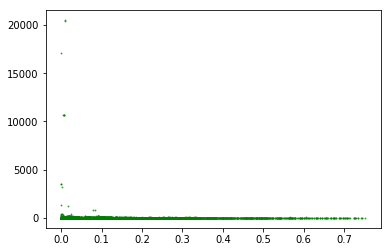

In [42]:
fig = plt.figure()
ax = plt.subplot()
ax.scatter(x1sum, y1sum,s=1, c='red', alpha=0.6)
ax.scatter(x2sum, y2sum,s=1, c='green', alpha=0.6) 

# ax.scatter(x1sum, y1sum,c='red', alpha=0.6)

In [24]:
pred = np.load('../data/kddcup99/pred.npy')
observe = np.load('../data/kddcup99/observe.npy')
data = np.load('../data/kddcup99/data.npy')       

In [25]:
TT = np.where((pred & observe) == 1)[0]
FF = np.where((pred | observe) == 0)[0]
TF = np.where((pred - observe) == -1)[0]
FT = np.where((pred - observe) == 1)[0]

In [26]:
# import random
# x = np.sum(np.concatenate((x1, x2), axis=0), axis = 1).squeeze()
# y = np.sum(np.concatenate((y1, y2), axis=0), axis = 1).squeeze()

# x_TT = x[TT]
# y_TT = y[TT]
# x_FF = x[FF]
# y_FF = y[FF]
# x_TF = x[TF]
# y_TF = y[TF]
# x_FT = x[FT]
# y_FT = y[FT]

x_TT = np.sum(data[:,121:], axis = 1).squeeze()[TT]
y_TT = np.sum(data[:,:121], axis = 1).squeeze()[TT]
x_FF = np.sum(data[:,121:], axis = 1).squeeze()[FF]
y_FF = np.sum(data[:,:121], axis = 1).squeeze()[FF]
x_TF = np.sum(data[:,121:], axis = 1).squeeze()[TF]
y_TF = np.sum(data[:,:121], axis = 1).squeeze()[TF]
x_FT = np.sum(data[:,121:], axis = 1).squeeze()[FT]
y_FT = np.sum(data[:,:121], axis = 1).squeeze()[FT]

/home/nana/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

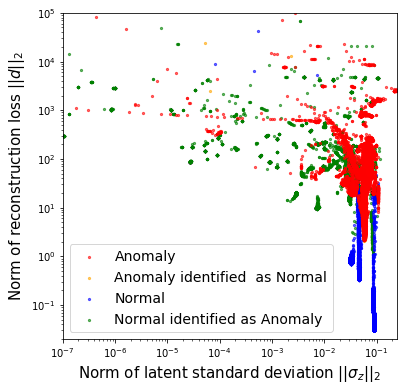

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.figure(figsize=(6,6))

ax = plt.subplot()

plt.xlim([0.0000001,0.25]) #thyroid 0,0.15 letter 0,0.6 kddcup99 0.0000001,0.25
plt.ylim([0.02,100000])  #thyroid 0,10  letter 0,60  kddcup99 0.02,100000
plt.yscale('log')
plt.xscale('log')

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15, # letter,thyroid 12 kddcup99 10
}

plt.xlabel('Norm of latent standard deviation $||\sigma_z||_2$', font2)
plt.ylabel('Norm of reconstruction loss $||d||_2$', font2)

l1 = ax.scatter(x_TF, y_TF, s=5, c='green', alpha=0.6)
l2 = ax.scatter(x_FT, y_FT, s=5, c='orange', alpha=0.6)
l3 = ax.scatter(x_TT, y_TT, s=5, c='blue', alpha=0.6)
l4 = ax.scatter(x_FF, y_FF, s=5, c='red', alpha=0.6) 

 
plt.legend(handles = [l4, l2, l3, l1], labels = ['Anomaly','Anomaly identified  as Normal','Normal','Normal identified as Anomaly'], loc = 'best', prop = {'size':14})

plt.savefig('../result/kddcup99.png', dpi=1000)